# ВКР на политфаке: how to?

## Part III: вот тебе и ВКР

Эта часть посвящена обработке запроса пользователя и формированию (не)красивой PDF

*Никита Смирнов, Анна Иванешкина, БПТ-181*

**0. Подгрузка всех необходимых пакетов**

In [5]:
import numpy as np
import pandas as pd 
import nltk

from nltk.tokenize import TweetTokenizer
from pymystem3 import Mystem

**1. Обработка: здесь происходит магия**

In [32]:
vkr = pd.read_csv(r'C:\Users\dramm\Desktop\vkr_lemm.csv', index_col='Unnamed: 0')

In [33]:
# Напишем три похожих функции, которые будут обрабатывать пользовательские запросы

def recommend1(surname):
    df = vkr.dropna(subset=['supervisor'])
    df = df[df['supervisor'].str.contains(surname, case=False)]
    return df

def recommend2(surname, keywords):
    df = vkr.dropna(subset=['supervisor', 'lemmannot'])
    df = vkr[vkr['supervisor'].str.contains(surname, na = False, case=False)]
    m = Mystem()
    keywords = m.lemmatize(keywords)
    for i in range(0, len(keywords)):
        df = df[df['lemmannot'].str.contains(keywords[i], na=False, case=False)]
    return df

def recommend3(keywords):
    m = Mystem()
    keywords = m.lemmatize(keywords)
    df = vkr.dropna(subset=['lemmannot'])
    for i in range(0, len(keywords)):
        df = df[df['lemmannot'].str.contains(keywords[i], na=False, case=False)]
    return df

**2. Ввод: здесь задаются параметры**

Введите свой запрос в следующем формате:

* Какой фильтр вы хотите (1: только научный руководитель, 2: научник и ключевые слова, 3: только ключевые слова)

* Введите фамилию научного руководителя (или оставьте поле пустым)

* Введите ключевые слова через запятую (или оставьте поле пустым)

In [34]:
req = int(input('Введите тип запроса (1: только научник, 2: научник и ключевые слова, 3: только ключевые слова)'))
surname = input('Введите фамилию научника (или оставьте поле пустым)')
keywords = input('Введите ключевые слова через запятую (или оставьте поле пустым)')

In [35]:
if req == 1: 
    res = recommend1(surname)
elif req == 2:
    res = recommend2(surname, keywords)
else:
    res = recommend3(keywords)

In [36]:
# Теперь сформируем ряд переменных для итогового отчета:

num = res.shape[0]
text_count = int(res.sum(numeric_only=True)[0])
supervisors = list(res.supervisor.unique())
superlinks = list(res.superlink.unique())
programs = list(res.program.unique())
papernames = list(res['papername'])
marks = list(res['mark'])
annotations = list(res['annot'])

if num > 0:
    message = f"""
        По вашему запросу найдено {num} ВКР.
        Эти работы писались на следующих ОП: {', '.join(programs)}.
        Возможнные научные руководители: {', '.join(supervisors)}. Их ссылки вы найдете в итоговом Excel-файле.
        Средняя оценка за эти работы: {res.mean(numeric_only=True)[2]}. 
        Текст есть для {text_count} ВКР. Ссылки на них вы также найдете в таблице.  
    """
else: message = 'По вашему запросу не найдено ВКР. Но вы можете стать первым!'

In [37]:
print(message)


        По вашему запросу найдено 1 ВКР.
        Эти работы писались на следующих ОП: Политология.
        Возможнные научные руководители: Сальникова Дарья Вячеславовна. Их ссылки вы найдете в итоговом Excel-файле.
        Средняя оценка за эти работы: nan. 
        Текст есть для 0 ВКР. Ссылки на них вы также найдете в таблице.  
    


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D2BFB8E9D0>]],
      dtype=object)

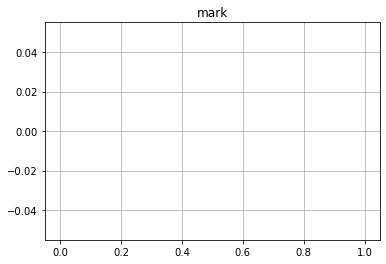

In [38]:
# Распределение оценок
res.hist(column='mark')

In [50]:
# Итоговый Excel:
res = res.drop(columns=['annottoken', 'lemmannot'])
res = res.rename(columns={
    'papername':'Название работы',
    'annotlink':'Ссылка',
    'text':'Текст',
    'student':'Студент',
    'year':'Год защиты',
    'supervisor':'Научный руководитель',
    'superlink':'Ссылка',
    'program':'ОП',
    'mark':'Оценка',
    'annot':'Аннотация',
})

file_name = r'C:\Users\dramm\Desktop\final.xlsx'

with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:
    workbook=writer.book
    title_format = workbook.add_format({'bold': True})
    header_format = workbook.add_format({
    'bold': True,
    'text_wrap': True,
    'valign': 'top',
    'fg_color': '#D7E4BC',
    'border': 1})

    worksheet=workbook.add_worksheet('Результат')
    writer.sheets['Результат'] = worksheet
    
    text_1 = 'Рекомендации по написанию ВКР'
    worksheet.write(0, 0, text_1, title_format)
    
    text_2 = f'Научный руководитель: {"нет" if surname == "" else surname}, ключевые слова: {"нет" if keywords == "" else keywords}'
    worksheet.write(1, 0, text_2)

    res.to_excel(writer, index=False, sheet_name='Результат', startrow=3, startcol=0)

    format = workbook.add_format({'text_wrap': True})
    format.set_align('center')
    format.set_align('vcenter')


    worksheet.set_column(0, 0, 35, format)
    worksheet.set_column(1, 1, 12, format)
    worksheet.set_column(2, 2, 10, format)
    worksheet.set_column(3, 3, 25, format)
    worksheet.set_column(4, 4, 12, format)
    worksheet.set_column(5, 5, 25, format)
    worksheet.set_column(6, 6, 15, format)
    worksheet.set_column(7, 7, 15, format)
    worksheet.set_column(8, 8, 10, format)
    worksheet.set_column(9, 9, 100, format)